In [ ]:
import sys
print(sys.version)


3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]


In [ ]:
%reset -f

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
##read excel
import pandas as pd
data_path = "/content/drive/MyDrive/prediction-divij/data-divij.xlsx"
df= pd.read_excel(data_path, engine='openpyxl')

df

,Date,Inventory
0,2023-07-03,0.00
1,2023-07-04,-5.00
2,2023-07-05,-4.80
3,2023-07-06,0.00
4,2023-07-07,19.45
...,...,...
350,2024-11-07,-32.15
351,2024-11-08,-11.05
352,2024-11-11,31.00
353,2024-11-12,13.60


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       355 non-null    datetime64[ns]
 1   Inventory  355 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.7 KB


In [ ]:
# add related columns

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day_of_Month'] = df['Date'].dt.day
df['Day_of_Week'] = df['Date'].dt.dayofweek
df['Day_of_Year'] = df['Date'].dt.dayofyear
df['Inventory_is_Positive'] = df['Inventory'].apply(lambda x: 1 if x > 0 else 0)

SEQ_LEN = 0
for i in range(1, SEQ_LEN + 1):
    df[f'Inventory_Lag_{i}'] = df['Inventory'].shift(i)

df.dropna(inplace=True)

df

,Date,Inventory,Year,Month,Day_of_Month,Day_of_Week,Day_of_Year,Inventory_is_Positive
0,2023-07-03,0.00,2023,7,3,0,184,0
1,2023-07-04,-5.00,2023,7,4,1,185,0
2,2023-07-05,-4.80,2023,7,5,2,186,0
3,2023-07-06,0.00,2023,7,6,3,187,0
4,2023-07-07,19.45,2023,7,7,4,188,1
...,...,...,...,...,...,...,...,...
350,2024-11-07,-32.15,2024,11,7,3,312,0
351,2024-11-08,-11.05,2024,11,8,4,313,0
352,2024-11-11,31.00,2024,11,11,0,316,1
353,2024-11-12,13.60,2024,11,12,1,317,1


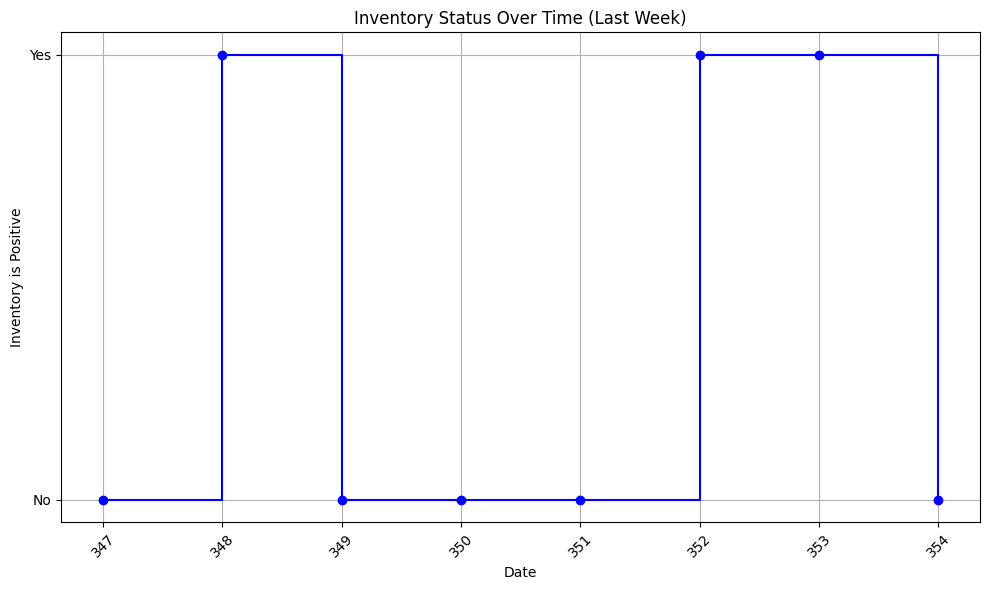

In [ ]:
#plot data for last 10 days

import matplotlib.pyplot as plt

# Filter for the last week
plot_data = df[df['Date'] >= (df['Date'].max() - pd.Timedelta(days=10))]

# Plot
plt.figure(figsize=(10, 6))
plt.step(plot_data.index, plot_data['Inventory_is_Positive'], where='post', marker='o', linestyle='-', color='b')
plt.title('Inventory Status Over Time (Last Week)')
plt.xlabel('Date')
plt.ylabel('Inventory is Positive')
plt.yticks([0, 1], ['No', 'Yes'])
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
df.columns

Index(['Date', 'Inventory', 'Year', 'Month', 'Day_of_Month', 'Day_of_Week',
       'Day_of_Year', 'Inventory_is_Positive', 'Inventory_Lag_1',
       'Inventory_Lag_2',
       ...
       'Inventory_Lag_91', 'Inventory_Lag_92', 'Inventory_Lag_93',
       'Inventory_Lag_94', 'Inventory_Lag_95', 'Inventory_Lag_96',
       'Inventory_Lag_97', 'Inventory_Lag_98', 'Inventory_Lag_99',
       'Inventory_Lag_100'],
      dtype='object', length=108)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Drop the 'Date' column
df_preprocessed = df.drop(columns=['Date'])


# Separate features and target
X = df_preprocessed.drop(columns=['Inventory_is_Positive' , "Inventory"])
y = df_preprocessed['Inventory_is_Positive']

print("X shape:", X.shape)
print("y shape:", y.shape)

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


X shape: (355, 5)
y shape: (355,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from xgboost import XGBClassifier

# Build and train the XGBoost model
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
y_test_binary = (y_test > 0).astype(int)
y_pred_binary = (y_pred > 0).astype(int)
accuracy = accuracy_score(y_test_binary, y_pred_binary)
mse = mean_squared_error(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Mean Squared Error: {mse}')


Accuracy: 0.5915492957746479
Mean Squared Error: 0.4084507042253521


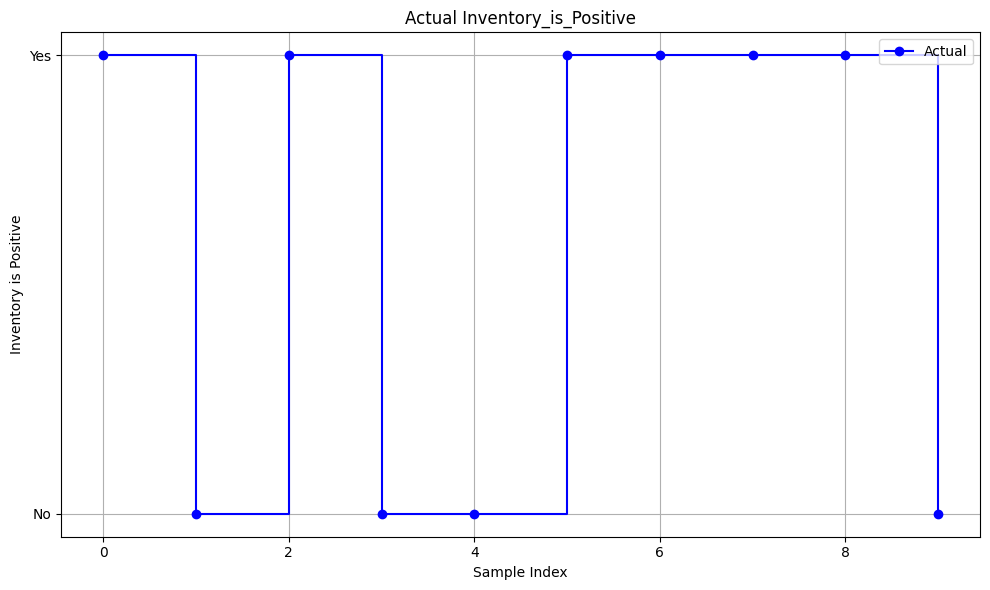

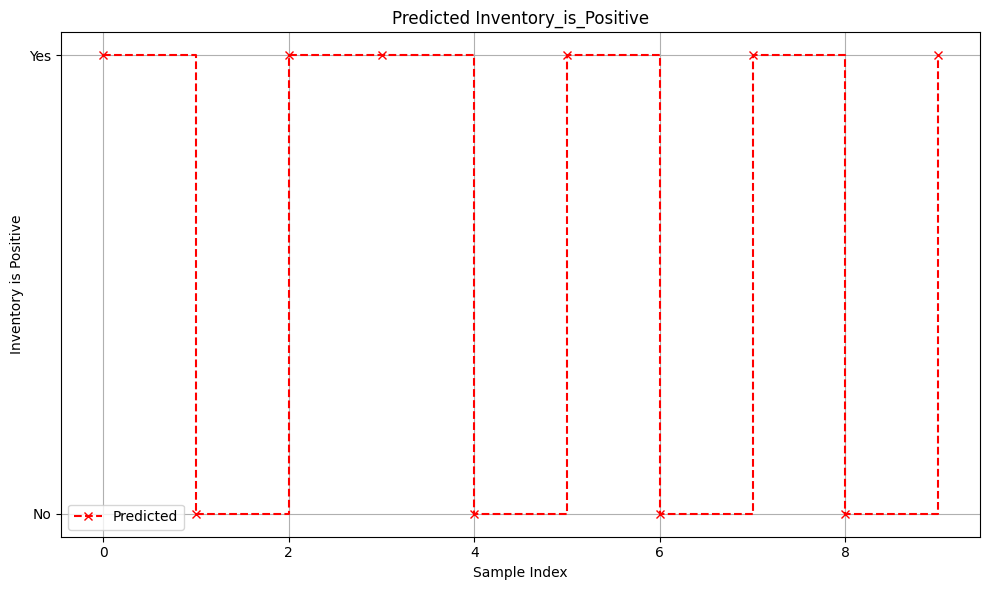

In [ ]:
# Create a DataFrame for plotting

last_plot = 10
plot_data = pd.DataFrame({
    'Actual': y_test[-last_plot:].values,
    'Predicted': y_pred.flatten()[-last_plot:]
})

# plot_data.reset_index(drop=True, inplace=True)
# Plot the actual values
plt.figure(figsize=(10, 6))
plt.step(plot_data.index, plot_data['Actual'], where='post', marker='o', linestyle='-', color='b', label='Actual')
plt.title('Actual Inventory_is_Positive')
plt.xlabel('Sample Index')
plt.ylabel('Inventory is Positive')
plt.yticks([0, 1], ['No', 'Yes'])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot the predicted values
plt.figure(figsize=(10, 6))
plt.step(plot_data.index, plot_data['Predicted'], where='post', marker='x', linestyle='--', color='r', label='Predicted')
plt.title('Predicted Inventory_is_Positive')
plt.xlabel('Sample Index')
plt.ylabel('Inventory is Positive')
plt.yticks([0, 1], ['No', 'Yes'])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()